In [97]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [98]:
data_dir = '/kaggle/input/asldataset/train'
batch_size = 32
img_size = (224, 224)

train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

val_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

test_dir = '/kaggle/input/asldataset/test'

test_ds = keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=img_size,
  batch_size=260)

Found 1300 files belonging to 26 classes.
Using 1040 files for training.
Found 1300 files belonging to 26 classes.
Using 260 files for validation.
Found 260 files belonging to 26 classes.


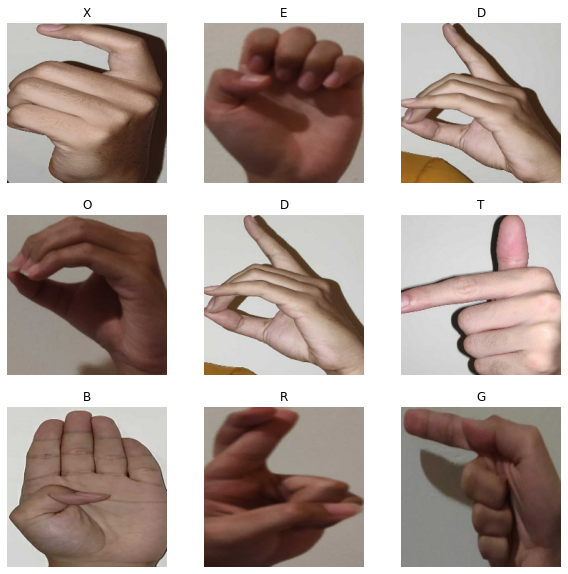

In [99]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [100]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 9
Number of test batches: 1


In [101]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [102]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
  ]
)

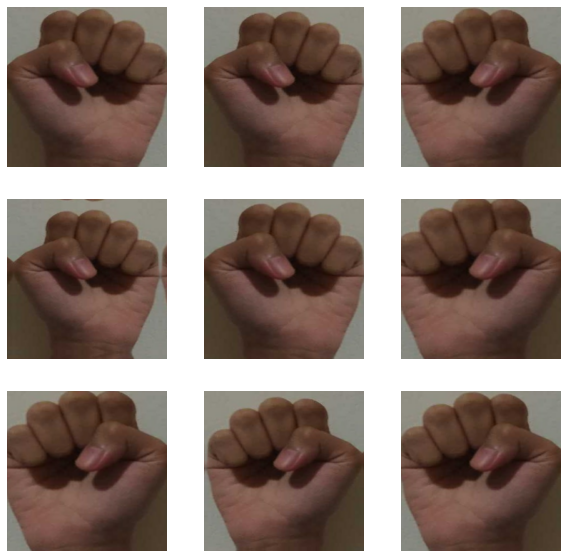

In [103]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [104]:
preprocess_input = keras.applications.vgg16.preprocess_input

In [105]:
IMG_SHAPE = img_size + (3,)
base_model = keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [106]:
base_model.trainable = False

In [107]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.AveragePooling2D(pool_size=(7, 7))(x)
x = layers.Flatten(name="flatten")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names))(x)

model = keras.Model(inputs, outputs)

In [108]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [109]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_3 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_3 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
average_pooling2d_3 (Average (None, 1, 1, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0   

In [110]:
len(model.trainable_variables)

4

In [111]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

9/9 [==============================] - 9s 261ms/step - loss: 5.0895 - accuracy: 0.0346


In [112]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}%".format(accuracy0*100))

initial loss: 5.09
initial accuracy: 3.46%


In [113]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
33/33 [==============================] - 9s 245ms/step - loss: 5.5901 - accuracy: 0.0413 - val_loss: 3.6893 - val_accuracy: 0.0615
Epoch 2/10
33/33 [==============================] - 5s 148ms/step - loss: 4.5429 - accuracy: 0.0692 - val_loss: 3.2089 - val_accuracy: 0.1154
Epoch 3/10
33/33 [==============================] - 5s 150ms/step - loss: 3.8820 - accuracy: 0.0808 - val_loss: 2.9062 - val_accuracy: 0.2000
Epoch 4/10
33/33 [==============================] - 5s 150ms/step - loss: 3.3235 - accuracy: 0.1240 - val_loss: 2.6328 - val_accuracy: 0.2692
Epoch 5/10
33/33 [==============================] - 5s 151ms/step - loss: 3.0897 - accuracy: 0.1692 - val_loss: 2.4231 - val_accuracy: 0.3385
Epoch 6/10
33/33 [==============================] - 5s 151ms/step - loss: 2.7703 - accuracy: 0.2269 - val_loss: 2.2533 - val_accuracy: 0.4077
Epoch 7/10
33/33 [==============================] - 5s 151ms/step - loss: 2.5869 - accuracy: 0.2615 - val_loss: 2.0979 - val_accuracy: 0.4500
Epoch 

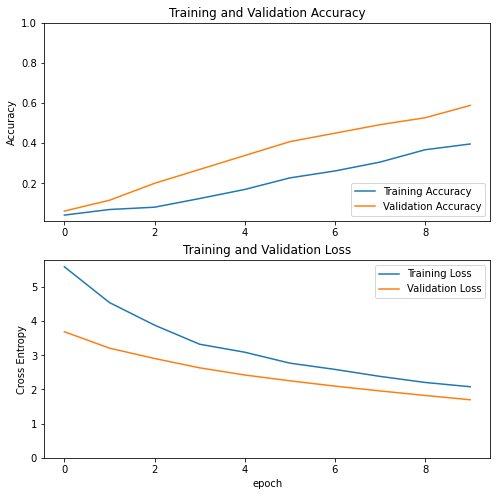

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [115]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

1/1 [==============================] - 38s 38s/step - loss: 2.1623 - accuracy: 0.3577
Test accuracy : 0.35769230127334595


In [116]:
base_model.trainable = True

In [117]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 145

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

Number of layers in the base model:  19


In [118]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [119]:
len(model.trainable_variables)

4

In [120]:
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/25
33/33 [==============================] - 6s 161ms/step - loss: 2.0349 - accuracy: 0.4048 - val_loss: 1.6854 - val_accuracy: 0.5885
Epoch 11/25
33/33 [==============================] - 5s 155ms/step - loss: 1.9583 - accuracy: 0.4337 - val_loss: 1.6732 - val_accuracy: 0.5923
Epoch 12/25
33/33 [==============================] - 5s 155ms/step - loss: 1.9681 - accuracy: 0.4260 - val_loss: 1.6595 - val_accuracy: 0.5885
Epoch 13/25
33/33 [==============================] - 5s 156ms/step - loss: 1.9659 - accuracy: 0.4202 - val_loss: 1.6479 - val_accuracy: 0.6000
Epoch 14/25
33/33 [==============================] - 5s 155ms/step - loss: 1.9534 - accuracy: 0.4452 - val_loss: 1.6359 - val_accuracy: 0.6000
Epoch 15/25
33/33 [==============================] - 5s 155ms/step - loss: 1.9593 - accuracy: 0.4452 - val_loss: 1.6250 - val_accuracy: 0.6077
Epoch 16/25
33/33 [==============================] - 5s 154ms/step - loss: 1.8641 - accuracy: 0.4635 - val_loss: 1.6132 - val_accuracy: 0.6077

In [121]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

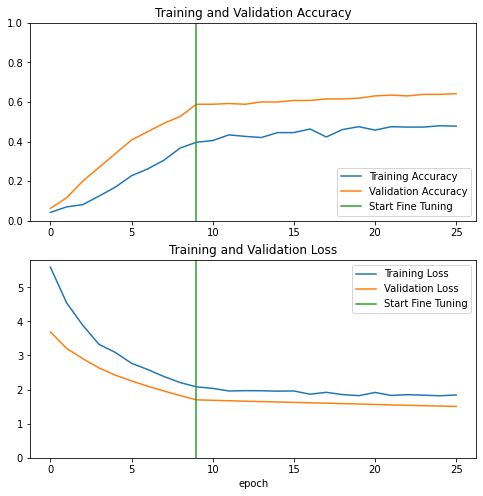

In [122]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, max(plt.ylim())])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [123]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 1s/step - loss: 2.0050 - accuracy: 0.4231
Test accuracy : 0.42307692766189575


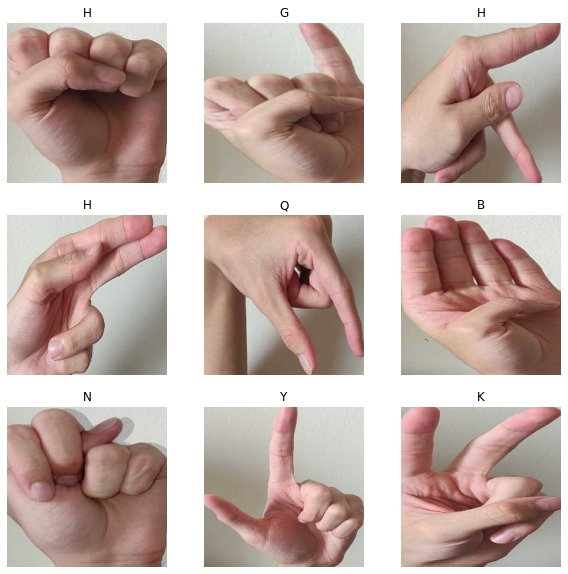

In [124]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.nn.softmax(predictions)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[np.argmax(predictions[i])])
    plt.axis("off")

In [125]:
y_pred = np.argmax(predictions, axis=1)
print(y_pred)
print(label_batch)

[ 7  6  7  7 16  1 13 24 10 14 14  9  0  6 12  9  1 12  0  1 10 21 10  6
  1  6 13  6  7 21  7 13  1 10  6  7 23 10 24  1 23  6  6 24  1 12  6  8
  0 14  6  7  3  6  1 13  1 20  5 10  1 24 23 10  7 13 10 24  1 13  7  7
 12  6  9  7 12 16  7 21 24  7  6  1  6 17 12  1 23  5 10 22  7 10  6 25
  0 21 12 24  5 17  6 10 22  6 17 18  3  6 21 23 17 10  5 16  6  1 17  9
  0  6 10 24 24  6 10 16 16 10 12 21  5 11 19  6  5  1  6 10 15 19  7  5
  6  6  0 22  0 25  6  1 10 23 11 18 22 10 10 20  7 23 15 12 21  1  3 25
 18  7 13 12  7  6  1 13 24 10 10 10 16 10  6  5  1  1 13  7 14  1  5 24
 12 13 25 10  7 14 12 13 24  1  1 10 10  7  1 21 21 10  1 24  1  7 10 10
 25  6 24 12 13 21  8  0 24 10 12 10 25  6 17  7 12  8  6 25 10 10  6 17
  6  6 10 23 25  7 25 24 10  7 10 21  5  7 11  6  6 12  6 21]
[18  8 15  7 16  1 13 11 21 14 14  8  0 19  0  3  0 12  0  0 20 17 22  6
 20  6 13  3  9 17 15 13 20 21  9  9 23 10 11 12 23  6 19 24  1  0  2  8
  0 14  9 24  3  9  1  4  8 20  5 21  0 24 23 22 16  4 18 11  

<AxesSubplot:>

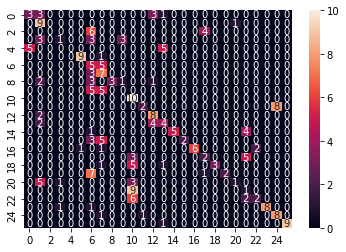

In [126]:
from tensorflow.math import confusion_matrix

conf_matrix = confusion_matrix(label_batch, y_pred)


import seaborn as sns
sns.heatmap(conf_matrix, annot=True)

In [127]:
model.save('modelVGG16.h5')

In [128]:
import os
os.chdir(r'/kaggle/working/')

In [129]:
from IPython.display import FileLink
FileLink(r'modelVGG16.h5')

/kaggle/working/modelVGG16.h5